(sec:titanic)=
# 타이타닉 데이터 분석

**주요 내용**

타이타닉<font size='2'>Titanic</font> 데이터셋을 데이터프레임으로 불러와서 전처리 하는 과정을 살펴 본다.

타이타닉은 1912년 4월 10일 영국을 떠나 미국 뉴욕으로 향하던 북 대서양 항해 중에 빙산과 충돌하여 침몰한다.
탑승객과 승무원 포함 2,224명이 승선했다가 그중 1,502명이 사망한 것으로 알려져 있다.

타이타닉 데이터셋은 탑승자의 신원과 관련된 정보와 생존 여부를 포함하며, 탑승자의 정보를 이용하여
생존 가능성을 예측하는 머신러닝 모델을 훈련시키는 예제로 자주 활용된다.

**기본 설정**

In [1]:
import pandas as pd
import numpy as np

랜덤 시드, 어레이 내부에 사용되는 부동소수점의 정확도(여기서는 소수점 이하 네자리까지 표시)를 지정한다.

In [2]:
np.random.seed(12345)
np.set_printoptions(precision=4, suppress=True)

그래프 크기를 지정한다.

In [3]:
import matplotlib.pyplot as plt

plt.rc('figure', figsize=(10, 6))

`seaborn` 라이브러리가 보다 세련된 그래프를 그린다.

In [4]:
import seaborn as sns

[`seaborn.set_theme()` 함수](https://seaborn.pydata.org/generated/seaborn.set_theme.html)를 이용하면
`seaborn` 스타일로 그래프 설정을 지정한다.

In [5]:
sns.set_theme()

사이킷런<font size='2'>scikit-learn</font> 라이브러리를 일부 이용한다.

In [6]:
from sklearn.datasets import fetch_openml

**주의사항**

열의 라벨을 데이터의 **특성**<font size='2'>feature</font>로 부르는
관습을 따라 여기서도 특성 표현을 사용한다.

## 타이타닉 데이터셋 불러오기

타이타닉 데이터셋을 불러온다.

- `fetch_openml()`: [openml](https://www.openml.org)에서 제공하는 데이터셋을 가져오는 함수.
- 여기서는 [타이타닉 데이터셋](https://www.openml.org/search?type=data&status=active&id=40945) 지정.

In [7]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


- 1309명 승객의 데이터 포함.

- `X`: 13개의 열(특성) 사용.

| 열 특성 | 의미 |
| :--- | :--- |
| Pclass | 승객 클래스(1 = 1등석; 2 = 2등석; 3 = 3등석) |
| name | 이름 |
| sex | 성(male=남성, female=여성) |
| age | 나이 |
| sibsp | 함께 승선한 형제, 자매, 배우자 수 |
| parch | 함께 승선한 부모 자식 수 |
| ticket | 티켓 번호 |
| fare | 티켓 요금 (영국 파운드) |
| cabin | 객실 번호 |
| embarked | 승선한 항구 (C = Cherbourg; Q = Queenstown; S = Southampton) |
| boat | 침몰시 탑승한 구명보트 번호 |
| body | 사망자인 경우 지정된 번호 |
| home.dest | 고향/목적지 |

In [8]:
X.shape

(1309, 13)

In [9]:
X.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

- `y`: 1309명 승객의 생존 여부를 담은 시리즈.
- 시리즈의 이름은 `survived`

| 열 특성 | 의미 |
| :--- | :--- |
| survived | 생존 여부 (0 = 사망; 1 = 생존) |`

In [10]:
y.name

'survived'

값들이 부동소수점이 아닌 범주형(category) 데이터인 문자열로 되어 있다.

In [11]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1309 entries, 0 to 1308
Series name: survived
Non-Null Count  Dtype   
--------------  -----   
1309 non-null   category
dtypes: category(1)
memory usage: 1.5 KB


보다 원할한 데이터 분석을 위해 정수 자료형으로 변환한다.

In [12]:
y = y.astype('i4')
y

0       1
1       1
2       0
3       0
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    0
Name: survived, Length: 1309, dtype: int32

## 데이터 정제

**데이터 정제**<font size='2'>data cleaning</font>는 부정확하거나 불완전하거나 부적절한 데이터를 탐지하여 수정, 삭제하는 과정을 가리킨다.
여기서는 다음 두 가지 과정을 소개한다.

- 데이터 분석에 필요하지 않은 특성 제거
- 결측치 처리

### 불필요 특성 제거

`'boat'`, `'body'`, `'home.dest'`, `ticket` 등을 특성으로 갖는 열은 생존 여부와 상관 없는 정보이기에 삭제한다.

**`DataFrame.drop()` 메서드**
- `inplace=True`: 기존 데이터프레임에서 직접 지정된 열 또는 행 삭제
- `inplace=False`: 지정된 열 또는 행을 삭제한 데이터프레임 생성. 기존 데이터프레임은 불변. 기본값으로 사용됨.

In [13]:
X.drop(['boat', 'body', 'home.dest', 'ticket'], axis=1, inplace=True)
X.head()

,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,211.3375,B5,S
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,151.5500,C22 C26,S
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,151.5500,C22 C26,S
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,151.5500,C22 C26,S
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,151.5500,C22 C26,S


### 결측치 처리

결측치의 존재 여부를 각 열에 대해 확인한다.

 - `DataFrame.info()` 메서드

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   float64 
 1   name      1309 non-null   object  
 2   sex       1309 non-null   category
 3   age       1046 non-null   float64 
 4   sibsp     1309 non-null   float64 
 5   parch     1309 non-null   float64 
 6   fare      1308 non-null   float64 
 7   cabin     295 non-null    object  
 8   embarked  1307 non-null   category
dtypes: category(2), float64(5), object(2)
memory usage: 74.5+ KB


- `DataFrame.isnull()`과 `DataFrame.any()` 메서드

In [15]:
X.isnull().any()

pclass      False
name        False
sex         False
age          True
sibsp       False
parch       False
fare         True
cabin        True
embarked     True
dtype: bool

결측치의 수와 비율을 각 열에 대해 확인한다.

- `DataFrame.sum()` 메서드

In [16]:
X.isnull().sum()

pclass         0
name           0
sex            0
age          263
sibsp          0
parch          0
fare           1
cabin       1014
embarked       2
dtype: int64

결측치의 비율을 각 열에 대해 계산한다.

- `len()` 함수

In [17]:
miss_vals = X.isnull().sum()/len(X) * 100
miss_vals

pclass       0.000000
name         0.000000
sex          0.000000
age         20.091673
sibsp        0.000000
parch        0.000000
fare         0.076394
cabin       77.463713
embarked     0.152788
dtype: float64

특성별 결측치 비율을 막대그래프로 그린다.

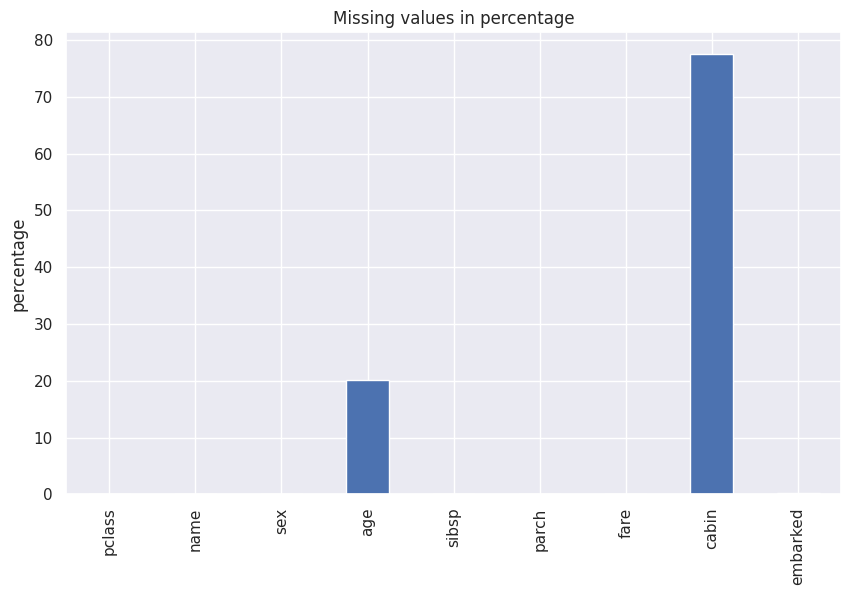

In [18]:
miss_vals.plot(kind='bar',
               title='Missing values in percentage',
               ylabel='percentage'
              )

plt.show()

많은 결측치가 포함된 객실(`cabin`) 열은 데이터분석에 도움이 되지 않기에 삭제한다.

In [19]:
X.drop(['cabin'], axis=1, inplace=True)

결측치를 다시 열별로 확인한다.

In [20]:
X.isnull().sum()

pclass        0
name          0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

## 데이터 전처리

**데이터 전처리**<font size='2'>data preprocessing</font>는
본격적인 데이터 분석을 위해 데이터를 조작하는 과정이다.

여기서는 다음 과정을 소개한다.

- 새로운 특성 추가

### 새로운 특성

형제자매, 배우자, 부모자식 수를 하나로 합쳐서
함께 승선한 가족의 수를 값으로 갖는
`family` 특성(열)을 생성하여 데이터셋에 추가한다.

**`family` 특성 추가**

- `pd.concat()` 함수
- `DataFrame.sum()` 메서드

In [22]:
X['family'] = X.parch + X.sibsp
X

,pclass,name,sex,age,sibsp,parch,fare,embarked,family
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,211.3375,S,0.0
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,151.5500,S,3.0
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,151.5500,S,3.0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,151.5500,S,3.0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,151.5500,S,3.0
...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,14.4542,C,1.0
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,14.4542,C,1.0
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,7.2250,C,0.0
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,7.2250,C,0.0


이제 `parch`, `sibsp` 두 특성은 필요하지 않기에 데이터셋에서 삭제한다.

In [23]:
X.drop(['parch', 'sibsp'], axis=1, inplace=True)
X

,pclass,name,sex,age,fare,embarked,family
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,211.3375,S,0.0
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,151.5500,S,3.0
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,151.5500,S,3.0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,151.5500,S,3.0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,151.5500,S,3.0
...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,14.4542,C,1.0
1305,3.0,"Zabour, Miss. Thamine",female,NaN,14.4542,C,1.0
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,7.2250,C,0.0
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,7.2250,C,0.0


**`is_alone` 특성 추가**

`family` 특성을 이용하여 1인 가족 여부를 확인하는 특성 `is_alone`을
아래 과정을 따라 추가한다.

- 먼저 모든 값을 문자열 `'0'`으로 지정한다.
- `family` 특성의 값이 0인 경우 문자열 `'1'`로 처리
- 0과 1을 문자열로 지정하여 범주로 처리되도록 함.

In [24]:
X['is_alone'] = '0'
mask = X['family'] == 0
X.loc[mask, 'is_alone'] = '1'
X

,pclass,name,sex,age,fare,embarked,family,is_alone
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,211.3375,S,0.0,1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,151.5500,S,3.0,0
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,151.5500,S,3.0,0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,151.5500,S,3.0,0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,151.5500,S,3.0,0
...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,14.4542,C,1.0,0
1305,3.0,"Zabour, Miss. Thamine",female,NaN,14.4542,C,1.0,0
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,7.2250,C,0.0,1
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,7.2250,C,0.0,1


In [25]:
X.is_alone

0       1
1       0
2       0
3       0
4       0
       ..
1304    0
1305    0
1306    1
1307    1
1308    1
Name: is_alone, Length: 1309, dtype: object

**`title` 특성 추가**

이름 특성을 제거하는 대신 호칭(`title`) 특성을 추가한다.

- 호칭이 `name` 특성에 포함됨
- 성 바로 뒤에 점으로 구분된 문자열이 호칭임.
- 문자열 메서드를 활용하여 호칭만 추출.
- `str.split()` 메서드의 `expand=True` 키워드 인자: 쪼개진 문자열을 값으로 갖는 데이프레임의 열 생성 여부 결정.

In [26]:
X['title'] =  X['name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
X.drop(["name"], axis=1, inplace=True)

X.head()

,pclass,sex,age,fare,embarked,family,is_alone,title
0,1.0,female,29.0000,211.3375,S,0.0,1,Miss
1,1.0,male,0.9167,151.5500,S,3.0,0,Master
2,1.0,female,2.0000,151.5500,S,3.0,0,Miss
3,1.0,male,30.0000,151.5500,S,3.0,0,Mr
4,1.0,female,25.0000,151.5500,S,3.0,0,Mrs


**`pd.crosstab()` 함수**

호칭에 따른 남녀 숫자를 확인한다.

In [27]:
pd.crosstab(X['title'], X['sex'])

sex,female,male
title,,
Capt,0,1
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,61


**`miss`, `mrs`, `ms` 특성 통합**

남성으로 구성된 `Master`와 `Mr`의 생존률에서 차이가 많이 난다.

- `Master`: 만 11세 이하 정도의 남자 아이
- `Mr`: 12살 이상 남성

In [34]:
X.age[X.title == 'Master'].max()

14.5

In [38]:
X.age[X.title == 'Master'].value_counts()

age
4.0000     5
1.0000     5
2.0000     5
9.0000     5
3.0000     4
6.0000     4
7.0000     3
13.0000    3
0.8333     3
8.0000     3
11.0000    2
10.0000    2
0.4167     1
14.5000    1
0.7500     1
0.9167     1
12.0000    1
0.3333     1
5.0000     1
0.6667     1
11.5000    1
Name: count, dtype: int64

In [35]:
X.age[X.title == 'Mr'].min()

11.0

In [29]:
print(f"Master: {np.sum(y[X.title == 'Master']) / len(X.title == 'Master')}")
print(f"Mr: {np.sum(y[X.title == 'Mr']) / len(X.title == 'Mr')}")

Master: 0.023682200152788387
Mr: 0.09396485867074103


반면에 `Miss`와 `Mrs`의 생존율이 거의 비슷하다.

In [30]:
print(f"Miss: {np.sum(y[X.title == 'Miss']) / len(X.title == 'Miss')}")
print(f"Mrs: {np.sum(y[X.title == 'Mrs']) / len(X.title == 'Mrs')}")

Miss: 0.13445378151260504
Mrs: 0.11841100076394194


따라서 `Mrs` 로 통일한다. 또한 `Ms`, `Lady`, `Mlle`, `Mme` 호칭도 1, 2명 뿐이고
모두 여성을 가리키기에 역시 `Mrs`로 통일한다.

- 부울 마스크와 열 인덱싱 활용

In [47]:
to_Mrs = lambda x: 'Mrs' if x in ['Ms', 'Lady', 'Mlle', 'Mme'] else x

In [48]:
X.title = X.title.apply(to_Mrs)
X

,pclass,sex,age,fare,embarked,family,is_alone,title
0,1.0,female,29.0000,211.3375,S,0.0,1,Mrs
1,1.0,male,0.9167,151.5500,S,3.0,0,Master
2,1.0,female,2.0000,151.5500,S,3.0,0,Mrs
3,1.0,male,30.0000,151.5500,S,3.0,0,Mr
4,1.0,female,25.0000,151.5500,S,3.0,0,Mrs
...,...,...,...,...,...,...,...,...
1304,3.0,female,14.5000,14.4542,C,1.0,0,Mrs
1305,3.0,female,NaN,14.4542,C,1.0,0,Mrs
1306,3.0,male,26.5000,7.2250,C,0.0,1,Mr
1307,3.0,male,27.0000,7.2250,C,0.0,1,Mr


호칭별 수를 확인하면 다음과 같다.

In [49]:
X.title.value_counts()

title
Mr              757
Mrs             463
Master           61
Dr                8
Rev               8
Col               4
Major             2
Capt              1
Sir               1
Dona              1
Jonkheer          1
the Countess      1
Don               1
Name: count, dtype: int64

10명 이하의 사람에게만 사용되는 호칭은 분석에 별로 도움되지 않는다.
하지만 여기서는 버리는 대신에 기타 등등을 가리키는 `etc`로 통일시켜 사용한다.

In [50]:
etc_titles = (X['title'].value_counts() < 10)
etc_titles

title
Mr              False
Mrs             False
Master          False
Dr               True
Rev              True
Col              True
Major            True
Capt             True
Sir              True
Dona             True
Jonkheer         True
the Countess     True
Don              True
Name: count, dtype: bool

In [51]:
X['title'] = X.title.apply(lambda x: 'etc' if etc_titles[x] else x)
X

,pclass,sex,age,fare,embarked,family,is_alone,title
0,1.0,female,29.0000,211.3375,S,0.0,1,Mrs
1,1.0,male,0.9167,151.5500,S,3.0,0,Master
2,1.0,female,2.0000,151.5500,S,3.0,0,Mrs
3,1.0,male,30.0000,151.5500,S,3.0,0,Mr
4,1.0,female,25.0000,151.5500,S,3.0,0,Mrs
...,...,...,...,...,...,...,...,...
1304,3.0,female,14.5000,14.4542,C,1.0,0,Mrs
1305,3.0,female,NaN,14.4542,C,1.0,0,Mrs
1306,3.0,male,26.5000,7.2250,C,0.0,1,Mr
1307,3.0,male,27.0000,7.2250,C,0.0,1,Mr


3 개의 호칭만 남는다.

In [52]:
X.title.value_counts()

title
Mr        757
Mrs       463
Master     61
etc        28
Name: count, dtype: int64

## 상관 분석

타이타닉 호의 침몰 사건에서 생존율과 기타 특성과의 상관 관계를 분석한다.
이를 위해 생존 여부 데이터를 `X`와 합친다.

In [53]:
X_comb = pd.concat([y, X], axis=1)
X_comb

,survived,pclass,sex,age,fare,embarked,family,is_alone,title
0,1,1.0,female,29.0000,211.3375,S,0.0,1,Mrs
1,1,1.0,male,0.9167,151.5500,S,3.0,0,Master
2,0,1.0,female,2.0000,151.5500,S,3.0,0,Mrs
3,0,1.0,male,30.0000,151.5500,S,3.0,0,Mr
4,0,1.0,female,25.0000,151.5500,S,3.0,0,Mrs
...,...,...,...,...,...,...,...,...,...
1304,0,3.0,female,14.5000,14.4542,C,1.0,0,Mrs
1305,0,3.0,female,NaN,14.4542,C,1.0,0,Mrs
1306,0,3.0,male,26.5000,7.2250,C,0.0,1,Mr
1307,0,3.0,male,27.0000,7.2250,C,0.0,1,Mr


생존 여부 특성과 다른 특성들과의 상관관계를 확인한다.

- `pclass`(승객 클래스) 특성과의 연관성이 가장 높음. 상위 클래스의 승객이 생존률이 높음.
- `fare`(티켓 가격) 특성 또한 동일한 이유로 생존 여부에 중요하게 연관됨.

### 수치형 특성 상관 관계

- `DataFrame.describe()` 메서드: 수치형 특성의 분포를 담은 데이터프레임 생성

In [54]:
X_comb.describe()

,survived,pclass,age,fare,family
count,1309.000000,1309.000000,1046.000000,1308.000000,1309.000000
mean,0.381971,2.294882,29.881135,33.295479,0.883881
std,0.486055,0.837836,14.413500,51.758668,1.583639
min,0.000000,1.000000,0.166700,0.000000,0.000000
25%,0.000000,2.000000,21.000000,7.895800,0.000000
50%,0.000000,3.000000,28.000000,14.454200,0.000000
75%,1.000000,3.000000,39.000000,31.275000,1.000000
max,1.000000,3.000000,80.000000,512.329200,10.000000


수치형 특성 목록은 다음과 같다.

In [55]:
num_features = X_comb.describe().columns
num_features

Index(['survived', 'pclass', 'age', 'fare', 'family'], dtype='object')

**피어슨 상관 계수**

수치형 특성들 피어슨 상관 계수<font size='2'>Pearson correlation coefficient</font>를 계산한다.

- `DataFrame.corr()` 함수

In [57]:
corr_df = X_comb[num_features].corr()
corr_df

,survived,pclass,age,fare,family
survived,1.000000,-0.312469,-0.055513,0.244265,0.026876
pclass,-0.312469,1.000000,-0.408106,-0.558629,0.050027
age,-0.055513,-0.408106,1.000000,0.178739,-0.240230
fare,0.244265,-0.558629,0.178739,1.000000,0.226492
family,0.026876,0.050027,-0.240230,0.226492,1.000000


히트맵을 이용하여 보다 명료하게 특성들사이의 선형 상관 관계를 확인한다.

- `sns.heatmap()` 함수

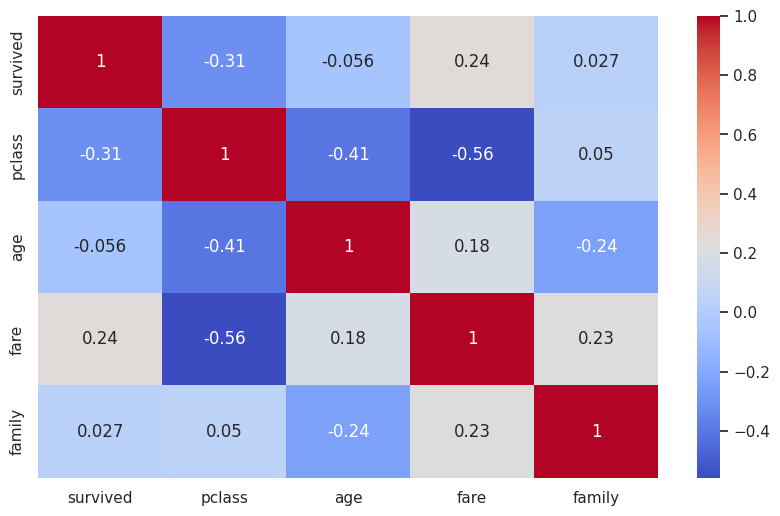

In [58]:
ax = sns.heatmap(corr_df, annot=True, cmap = "coolwarm")

**성별 생존률**

사망자(0)과 생존자(1) 수를 확인한다.

In [65]:
X_comb.survived.value_counts()

survived
0    809
1    500
Name: count, dtype: int64

막대 그래프로 그린다.

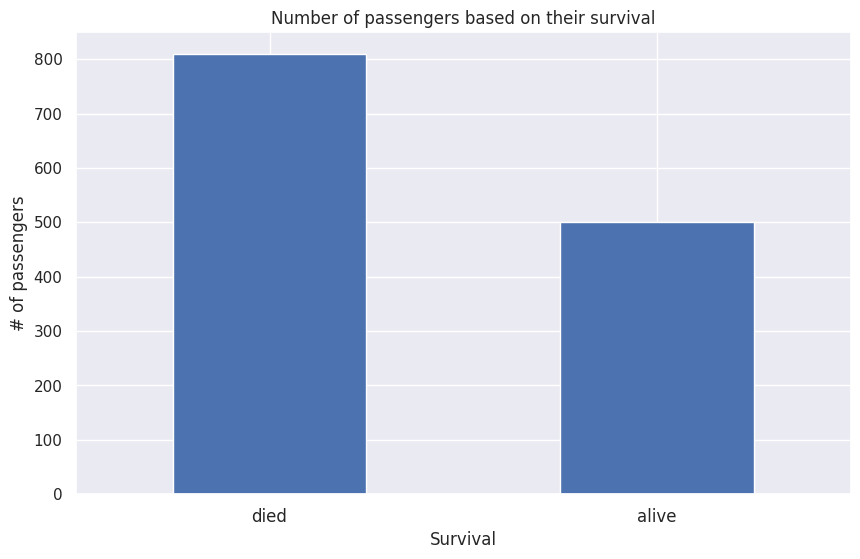

In [69]:
fig, ax = plt.subplots()

X_comb['survived'].value_counts().plot(kind='bar', xticks=[0, 1], rot=0)

ax.set_xticklabels(['died', 'alive'], fontsize=12)
ax.set(xlabel='Survival', ylabel='# of passengers', title='Number of passengers based on their survival')
plt.show()

남성의 생존률을 계산한다.

- 남성 생존자 수

In [61]:
n_men_survived = ((X_comb['survived'][X_comb.sex == 'male']) == 1).sum()
n_men_survived

161

- 남성 탑승객 수

In [62]:
n_men = X_comb.sex.value_counts().loc['male']
n_men

843

- 남성 생존률

In [63]:
n_men_survived / n_men

0.19098457888493475

- `sns.barplot()` 함수를 이용하면 쉽게 성별 생존률을 확인할 수 있다.

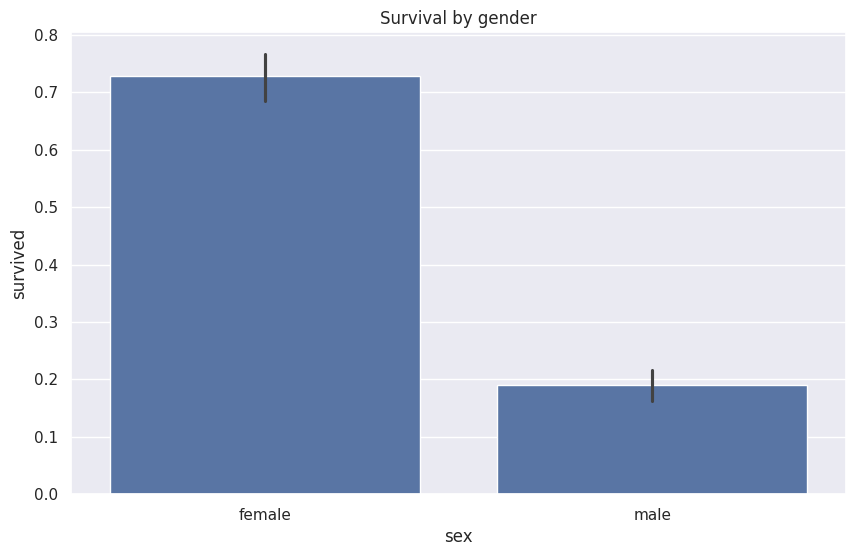

In [64]:
sns.barplot(data=X_comb,
            x='sex',
            y='survived'
           )

plt.title('Survival by gender')
plt.show()

**연령별 생존자**

나이 특성엔 결측치가 많다.

In [70]:
X_comb.age.isnull().sum()

263

- 결측치 제거 후 전체 탑승객의 나이

In [71]:
X_comb.age.dropna()

0       29.0000
1        0.9167
2        2.0000
3       30.0000
4       25.0000
         ...   
1301    45.5000
1304    14.5000
1306    26.5000
1307    27.0000
1308    29.0000
Name: age, Length: 1046, dtype: float64

- 생존자 나이

In [72]:
X_comb['age'][X_comb.survived == 1].dropna()

0       29.0000
1        0.9167
5       48.0000
6       63.0000
8       53.0000
         ...   
1261    63.0000
1277    22.0000
1286    38.0000
1290    47.0000
1300    15.0000
Name: age, Length: 427, dtype: float64

전체 탑승자와 생존자를 연령별로 구분하여 히스토그램을 그린다.

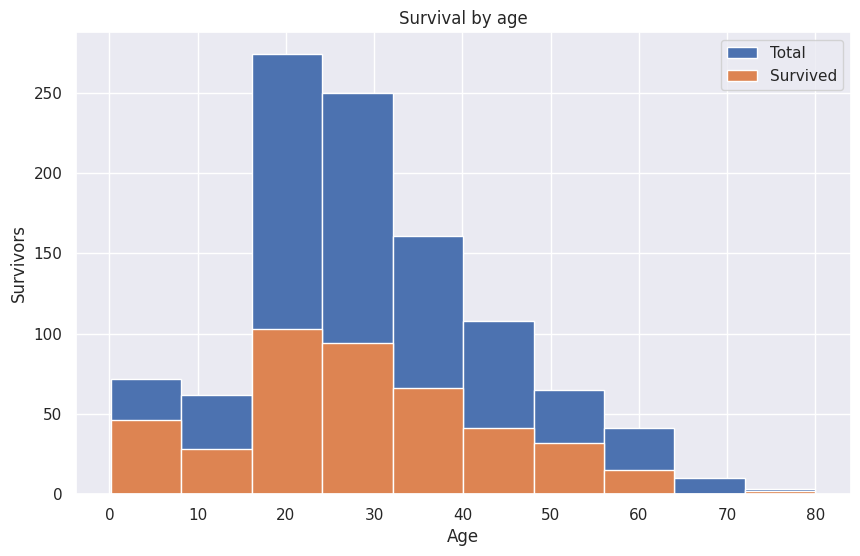

In [74]:
fig, ax = plt.subplots()

ax.hist(X_comb['age'].dropna(), label='Total') # 원래는 연령별 전체 탑승자 수. 하지만 생존자 수에 의해 일부 구간 가려짐.
ax.hist(X_comb['age'].dropna()[X_comb.survived == 1], label='Survived')

plt.ylabel('Survivors')
plt.xlabel('Age')
plt.title('Survival by age')
plt.legend()
plt.show()

**연습 문제**

연령별 생존률을 `bar.plot()` 함수를 이용하여 구하라.

힌트: 10살 단위로 구간을 나눈다.

**탑승자 클래스(1-3등 클래스)별 생존률**

- 클래스별 탑승자 수

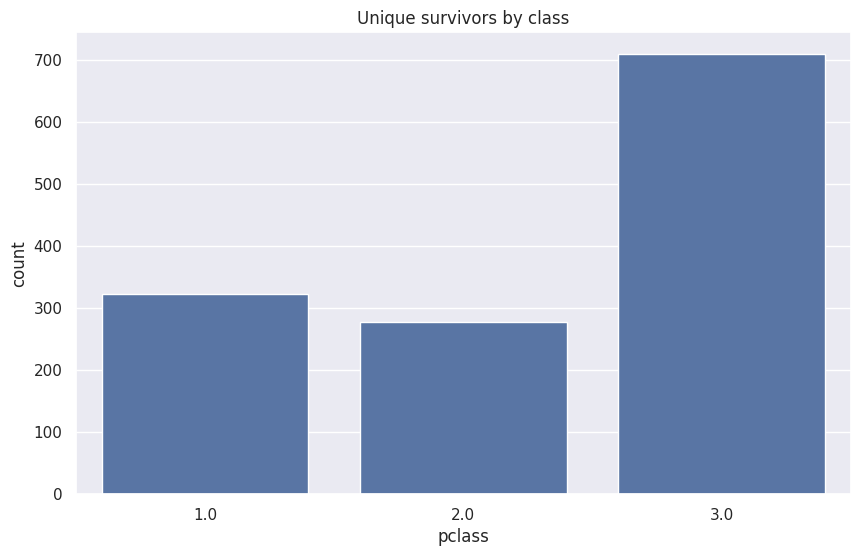

In [75]:
sns.countplot(x='pclass', data=X_comb)

plt.title('Unique survivors by class')
plt.show()

- 클래스별 생존률

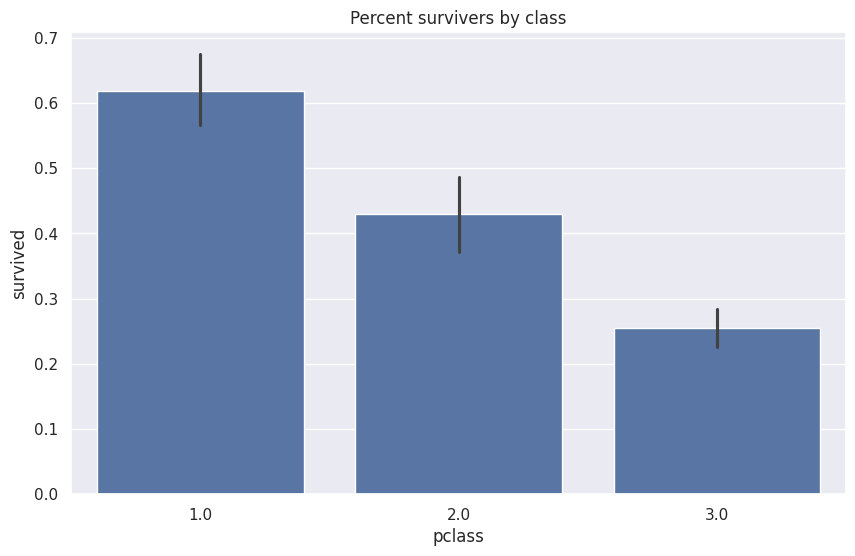

In [76]:
sns.barplot(x='pclass', y='survived', data=X_comb)

plt.title('Percent survivers by class')
plt.show()

**오차 막대**

- `errorbar` 옵션 인자
    - `ci`: 신뢰 구간<font size='2'>confidence interval</font>
    - `pi`: 백분위수 구간<font size='2'>percentile interval</font>
    - `se`: 표준 오차<font size='2'>standard error</font>
    - `sd`: 표준 편차<font size='2'>standard deviation</font> (기본값)
    
- 참고: [Statistical estimation and error bars](https://seaborn.pydata.org/tutorial/error_bars.html)